In [1]:
from utils.ifa_meander_project_v2.geometry import *
from utils.ifa_meander_project_v2.meshing import *
from utils.ifa_meander_project_v2.frequency import *
from utils.ifa_meander_project_v2.simulation import *

fC      = 868e6  # fréquence centrale en Hz
delta_f = 4e6  # écart entre les échantillons en Hz
print(f"delta_f = {delta_f/1e6:.2f} MHz")
nPoints = 31     # nombre d'échantillons

fLow, fHigh, frequencies = calc_frequencies(fC, delta_f, nPoints)
print(f"fLow = {fLow/1e6:.2f} MHz, fHigh = {fHigh/1e6:.2f} MHz, nPoints = {nPoints}")

In [2]:
""" fC      = 868e6
fLow    = 700e6
fHigh   = 1000e6

nPoints = calculate_nPoints(fLow, fHigh, fC, 80)
accuracy= 0.01
print(f"nPoints = {nPoints}")
frequencies = np.linspace(fLow, fHigh, nPoints)
fc_index = np.where(frequencies == fC)[0][0]
print(f"fc_index = {fc_index}") """

fLow = 700e6
fHigh = 1000e6
fC = 868e6
step = 4e6

frequencies, fc_index, nPoints = generate_frequencies(fLow, fHigh, fC, step)

print(f"Nombre de fréquences (nPoints) : {nPoints}")
print(f"Index de fC : {fc_index}")



Nombre de fréquences (nPoints) : 76
Index de fC : 42


In [3]:
mesh_name = "ifa_meander.msh"
save_mesh_folder = 'data/gmsh_files/'
ifa_meander_mat = 'data/antennas_mesh/ifa_meander.mat'
ifa_meander_msh = save_mesh_folder + mesh_name

In [4]:
a = 27 / 1000  # Largeur
b = 55 / 1000  # Hauteur

terminal_a = 92 / 1000
terminal_b = b
x_t = np.array([-terminal_a + a, 0, 0, -terminal_a + a])
y_t = np.array([terminal_b, terminal_b, 0, 0])

# On fixe le short feed et la largur de piste
if b / a > 2:
    print(f"On est dans le cas où b > 2*a -> {b / a}")
    largeur_piste    = a / 5          # Valeur Minimale    
    distance_meandre = a / 5          # Valeur choisie en fonction du resulat de analyse_dist_meandre.ipynb
    """ if b > 60 / 1000:
        print(f"On est dans le cas où b >= 2*a et b > 60 mm -> {b / a}")
        largeur_piste    = a / 20          # Valeur Minimale    
        distance_meandre = a / 20          # Valeur choisie en fonction du resulat de analyse_dist_meandre.ipynb """
else:
    print(f"On est dans le cas où b <= 2*a -> {b / a}")
    largeur_piste    = a / 10          # Valeur Minimale    
    distance_meandre = a / 10          # Valeur choisie en fonction du resulat de analyse_dist_meandre.ipynb
# feed             = 0.5 * b          # Valuer Positionné a la moitié du ground plane -- 25 mm
# feed             = (1/3) * b + (1/3) * a
# feed               = (-1/14) * b + (8/7) * a             # Best so far
# feed = b - 3 * largeur_piste / 2 - 1 / 1000
feed = 0.5 * b
# feed = largeur_piste / 2
feed_point       = [0, feed, 0]      # On alimente au short feed
mesh_size = 4 * largeur_piste

# Affichage des valeurs
print(f"largeur_piste = {largeur_piste * 1000:.2f} mm")
print(f"distance_meandre = {distance_meandre * 1000:.2f} mm")
print(f"feed = {feed * 1000:.2f} mm")
print(f"mesh_size = {mesh_size * 1000:.2f}")

On est dans le cas où b > 2*a -> 2.037037037037037
largeur_piste = 5.40 mm
distance_meandre = 5.40 mm
feed = 27.50 mm
mesh_size = 21.60


In [5]:
def creation_ifa(largeur, hauteur, width, dist_meandre, feed, x_t, y_t, save_mesh_folder, mesh_name, mesh_size):
    x, y, N, distance_meandre = ifa_creation(largeur, hauteur, width, dist_meandre)
    x_m, y_m = trace_meander(x, y, width)
    feed_wid = width # La largeur de la piste est la meme partout
    feed_x = np.array([0, distance_meandre, distance_meandre, 0])
    feed_y = np.array([feed + feed_wid/2, feed + feed_wid/2, feed -feed_wid/2, feed - feed_wid/2])
    antenna_ifa_meander(x_m, y_m, x_t, y_t, feed_x, feed_y, save_mesh_folder, mesh_name, mesh_size)
    extract_msh_to_mat(ifa_meander_msh, ifa_meander_mat)
    return N, distance_meandre

def plot_s11_curve(fLow, fHigh, nPoints, s11_db, fC=None):
    from matplotlib import pyplot as plt
    frequencies = np.linspace(fLow, fHigh, nPoints)
    frequencies_mhz = np.array(frequencies) / 1e6
    s11_db = np.array(s11_db)

    # Trouver le minimum de S11
    min_index = np.argmin(s11_db)
    f_resonance = frequencies[min_index] / 1e6
    s11_min = s11_db[min_index]

    # Tracé
    fig_size = 7
    Fibonacci = (1 + np.sqrt(5)) / 2
    plt.figure(figsize=(fig_size, fig_size / Fibonacci))
    plt.plot(frequencies_mhz, s11_db, label="S11 (dB)", color='blue')
    plt.plot(f_resonance, s11_min, 'ro', 
            label=f"Résonance: {f_resonance:.2f} MHz (S11={s11_min:.2f} dB)")
    
    if fC:
        fC_mhz = fC / 1e6
        idx_fc = np.argmin(np.abs(frequencies - fC))
        s11_fc = s11_db[idx_fc]
        plt.axvline(fC_mhz, color='green', linestyle='--', 
                   label=f"fC = {fC_mhz:.2f} MHz (S11={s11_fc:.2f} dB)")

    plt.xlabel("Fréquence (MHz)")
    plt.ylabel("S11 (dB)")
    plt.title("Courbe de S11 vs Fréquence")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def adapt_with_ratio_square(distance_meandre, largeur_piste, ratio):
    return distance_meandre / (ratio**2), largeur_piste / (ratio**2)

def adapt_with_ratio_cube(distance_meandre, largeur_piste, ratio):
    return distance_meandre / (ratio**3), largeur_piste / (ratio**3)


------------------------------------------------------Iteration N°1------------------------------------------------------

distance meandres = 5.400 mm

Number of meanders = 2

New distance meandres = 8.100 mm
Largeur de piste ifa = 5.400 mm
position feed = 27.500 mm

Simulation 1/76 | f = 700.00 MHz | S11 = -0.60 dB
Simulation 2/76 | f = 704.00 MHz | S11 = -0.64 dB
Simulation 3/76 | f = 708.00 MHz | S11 = -0.67 dB
Simulation 4/76 | f = 712.00 MHz | S11 = -0.71 dB
Simulation 5/76 | f = 716.00 MHz | S11 = -0.75 dB
Simulation 6/76 | f = 720.00 MHz | S11 = -0.80 dB
Simulation 7/76 | f = 724.00 MHz | S11 = -0.85 dB
Simulation 8/76 | f = 728.00 MHz | S11 = -0.90 dB
Simulation 9/76 | f = 732.00 MHz | S11 = -0.95 dB
Simulation 10/76 | f = 736.00 MHz | S11 = -1.01 dB
Simulation 11/76 | f = 740.00 MHz | S11 = -1.07 dB
Simulation 12/76 | f = 744.00 MHz | S11 = -1.14 dB
Simulation 13/76 | f = 748.00 MHz | S11 = -1.21 dB
Simulation 14/76 | f = 752.00 MHz | S11 = -1.29 dB
Simulation 15/76 | f = 75

Simulation 43/76 | f = 868.00 MHz | S11 = -12.02 dB
Simulation 44/76 | f = 872.00 MHz | S11 = -13.42 dB
Simulation 45/76 | f = 876.00 MHz | S11 = -15.11 dB
Simulation 46/76 | f = 880.00 MHz | S11 = -17.23 dB
Simulation 47/76 | f = 884.00 MHz | S11 = -20.06 dB
Simulation 48/76 | f = 888.00 MHz | S11 = -24.24 dB
Simulation 49/76 | f = 892.00 MHz | S11 = -32.22 dB
Simulation 50/76 | f = 896.00 MHz | S11 = -34.76 dB
Simulation 51/76 | f = 900.00 MHz | S11 = -25.41 dB
Simulation 52/76 | f = 904.00 MHz | S11 = -20.92 dB
Simulation 53/76 | f = 908.00 MHz | S11 = -18.01 dB
Simulation 54/76 | f = 912.00 MHz | S11 = -15.88 dB
Simulation 55/76 | f = 916.00 MHz | S11 = -14.21 dB
Simulation 56/76 | f = 920.00 MHz | S11 = -12.85 dB
Simulation 57/76 | f = 924.00 MHz | S11 = -11.70 dB
Simulation 58/76 | f = 928.00 MHz | S11 = -10.73 dB
Simulation 59/76 | f = 932.00 MHz | S11 = -9.89 dB
Simulation 60/76 | f = 936.00 MHz | S11 = -9.15 dB
Simulation 61/76 | f = 940.00 MHz | S11 = -8.49 dB
Simulation 62/7


📡 Résultats de simulation :
→ Fréquence de résonance = 896.00 MHz
→ Impédance à f_res      = 50.49+1.77j Ω

S11 en dB : [ -0.60453732  -0.63856268  -0.67482409  -0.71349653  -0.754771
  -0.79885619  -0.84598027  -0.896393    -0.95036804  -1.00820548
  -1.07023472  -1.13681769  -1.20835245  -1.28527721  -1.36807483
  -1.45727793  -1.55347456  -1.65731468  -1.76951738  -1.89087913
  -2.0222831   -2.16470982  -2.31924933  -2.4871152   -2.66966078
  -2.86839816  -3.0850205   -3.32142866  -3.57976332  -3.86244428
  -4.17221926  -4.51222549  -4.88606891  -5.29792787  -5.75269141
  -6.25614778  -6.81524665  -7.43847278  -8.13639232  -8.92247553
  -9.81437946 -10.83603296 -12.02120387 -13.42001074 -15.11185477
 -17.23420897 -20.05812736 -24.24458538 -32.21859803 -34.76009425
 -25.41380142 -20.92095587 -18.011088   -15.87775463 -14.20744541
 -12.84570833 -11.70493062 -10.73049532  -9.88595948  -9.14572277
  -8.49106181  -7.90783233  -7.38506276  -6.91405389  -6.48778052
  -6.1004808   -5.74736

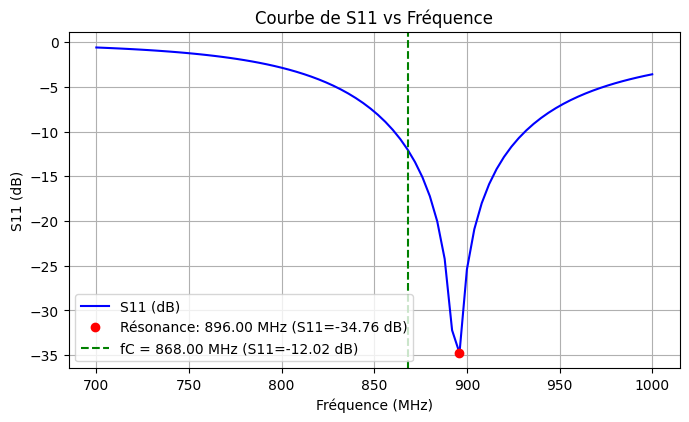


Ratio = 1.032258064516129


We are within 2% of fc!


------------------------------------------------------Iteration N°2------------------------------------------------------

distance meandres = 5.400 mm

Number of meanders = 2

New distance meandres = 8.100 mm
Largeur de piste ifa = 5.400 mm
position feed = 29.303 mm

Simulation 1/76 | f = 700.00 MHz | S11 = -0.63 dB
Simulation 2/76 | f = 704.00 MHz | S11 = -0.67 dB
Simulation 3/76 | f = 708.00 MHz | S11 = -0.71 dB
Simulation 4/76 | f = 712.00 MHz | S11 = -0.75 dB
Simulation 5/76 | f = 716.00 MHz | S11 = -0.80 dB
Simulation 6/76 | f = 720.00 MHz | S11 = -0.85 dB
Simulation 7/76 | f = 724.00 MHz | S11 = -0.90 dB
Simulation 8/76 | f = 728.00 MHz | S11 = -0.96 dB
Simulation 9/76 | f = 732.00 MHz | S11 = -1.02 dB
Simulation 10/76 | f = 736.00 MHz | S11 = -1.08 dB
Simulation 11/76 | f = 740.00 MHz | S11 = -1.16 dB
Simulation 12/76 | f = 744.00 MHz | S11 = -1.23 dB
Simulation 13/76 | f = 748.00 MHz | S11 = -1.31 dB
Simulation 14/76 | f =

Simulation 43/76 | f = 868.00 MHz | S11 = -16.79 dB
Simulation 44/76 | f = 872.00 MHz | S11 = -19.62 dB
Simulation 45/76 | f = 876.00 MHz | S11 = -23.83 dB
Simulation 46/76 | f = 880.00 MHz | S11 = -32.21 dB
Simulation 47/76 | f = 884.00 MHz | S11 = -35.68 dB
Simulation 48/76 | f = 888.00 MHz | S11 = -25.17 dB
Simulation 49/76 | f = 892.00 MHz | S11 = -20.58 dB
Simulation 50/76 | f = 896.00 MHz | S11 = -17.64 dB
Simulation 51/76 | f = 900.00 MHz | S11 = -15.50 dB
Simulation 52/76 | f = 904.00 MHz | S11 = -13.83 dB
Simulation 53/76 | f = 908.00 MHz | S11 = -12.47 dB
Simulation 54/76 | f = 912.00 MHz | S11 = -11.34 dB
Simulation 55/76 | f = 916.00 MHz | S11 = -10.37 dB
Simulation 56/76 | f = 920.00 MHz | S11 = -9.53 dB
Simulation 57/76 | f = 924.00 MHz | S11 = -8.80 dB
Simulation 58/76 | f = 928.00 MHz | S11 = -8.15 dB
Simulation 59/76 | f = 932.00 MHz | S11 = -7.58 dB
Simulation 60/76 | f = 936.00 MHz | S11 = -7.07 dB
Simulation 61/76 | f = 940.00 MHz | S11 = -6.61 dB
Simulation 62/76 |


📡 Résultats de simulation :
→ Fréquence de résonance = 884.00 MHz
→ Impédance à f_res      = 49.90+1.64j Ω

S11 en dB : [ -0.63339136  -0.6707838   -0.71077624  -0.75358484  -0.79944677
  -0.84862255  -0.90139865  -0.95809038  -1.0190452   -1.08464637
  -1.15531709  -1.23152519  -1.31378838  -1.40268018  -1.49883664
  -1.60296394  -1.71584703  -1.83835945  -1.9714745   -2.11627808
  -2.27398346  -2.44594829  -2.63369448  -2.83893153  -3.06358413
  -3.3098253   -3.58011669  -3.87725823  -4.20445048  -4.56537427
  -4.96429448  -5.40619805  -5.89698154  -6.44371193  -7.05499816
  -7.74153489  -8.51692246  -9.39894758 -10.41166905 -11.58899418
 -12.98122486 -14.66810716 -16.78806136 -19.61576666 -23.83351324
 -32.21342419 -35.67873729 -25.16961083 -20.57677595 -17.64059557
 -15.49941258 -13.82864093 -12.4702507  -11.33510695 -10.36780824
  -9.53144456  -8.80010553  -8.15484515  -7.58135043  -7.0685175
  -6.60754133  -6.19131125  -5.8139963   -5.47075257  -5.1575115
  -4.87082341  -4.60773

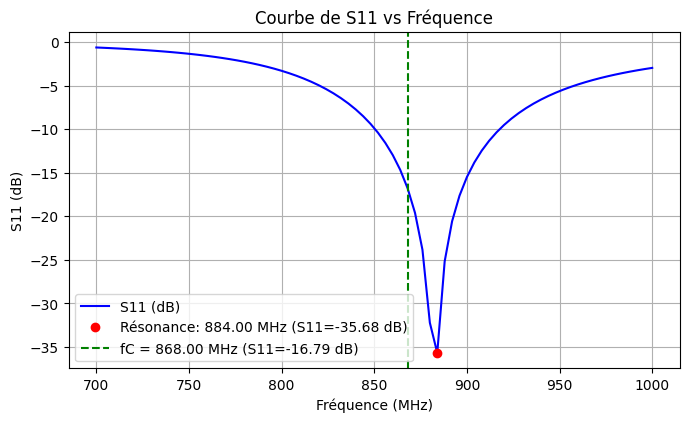


Ratio = 1.0184331797235022


We are within 2% of fc!


------------------------------------------------------Iteration N°3------------------------------------------------------

distance meandres = 5.400 mm

Number of meanders = 2

New distance meandres = 8.100 mm
Largeur de piste ifa = 5.400 mm
position feed = 30.393 mm

Simulation 1/76 | f = 700.00 MHz | S11 = -0.65 dB
Simulation 2/76 | f = 704.00 MHz | S11 = -0.69 dB
Simulation 3/76 | f = 708.00 MHz | S11 = -0.73 dB
Simulation 4/76 | f = 712.00 MHz | S11 = -0.78 dB
Simulation 5/76 | f = 716.00 MHz | S11 = -0.83 dB
Simulation 6/76 | f = 720.00 MHz | S11 = -0.88 dB
Simulation 7/76 | f = 724.00 MHz | S11 = -0.93 dB
Simulation 8/76 | f = 728.00 MHz | S11 = -0.99 dB
Simulation 9/76 | f = 732.00 MHz | S11 = -1.06 dB
Simulation 10/76 | f = 736.00 MHz | S11 = -1.13 dB
Simulation 11/76 | f = 740.00 MHz | S11 = -1.20 dB
Simulation 12/76 | f = 744.00 MHz | S11 = -1.28 dB
Simulation 13/76 | f = 748.00 MHz | S11 = -1.37 dB
Simulation 14/76 | f 

Simulation 43/76 | f = 868.00 MHz | S11 = -18.87 dB
Simulation 44/76 | f = 872.00 MHz | S11 = -22.64 dB
Simulation 45/76 | f = 876.00 MHz | S11 = -29.26 dB
Simulation 46/76 | f = 880.00 MHz | S11 = -38.64 dB
Simulation 47/76 | f = 884.00 MHz | S11 = -26.56 dB
Simulation 48/76 | f = 888.00 MHz | S11 = -21.40 dB
Simulation 49/76 | f = 892.00 MHz | S11 = -18.22 dB
Simulation 50/76 | f = 896.00 MHz | S11 = -15.94 dB
Simulation 51/76 | f = 900.00 MHz | S11 = -14.19 dB
Simulation 52/76 | f = 904.00 MHz | S11 = -12.77 dB
Simulation 53/76 | f = 908.00 MHz | S11 = -11.60 dB
Simulation 54/76 | f = 912.00 MHz | S11 = -10.60 dB
Simulation 55/76 | f = 916.00 MHz | S11 = -9.73 dB
Simulation 56/76 | f = 920.00 MHz | S11 = -8.98 dB
Simulation 57/76 | f = 924.00 MHz | S11 = -8.32 dB
Simulation 58/76 | f = 928.00 MHz | S11 = -7.73 dB
Simulation 59/76 | f = 932.00 MHz | S11 = -7.21 dB
Simulation 60/76 | f = 936.00 MHz | S11 = -6.74 dB
Simulation 61/76 | f = 940.00 MHz | S11 = -6.31 dB
Simulation 62/76 | 


📡 Résultats de simulation :
→ Fréquence de résonance = 880.00 MHz
→ Impédance à f_res      = 48.87+0.26j Ω

S11 en dB : [ -0.65286165  -0.69203113  -0.7339651   -0.77889641  -0.82708079
  -0.87879943  -0.93436179  -0.99410883  -1.05841663  -1.12770038
  -1.20241899  -1.28308021  -1.37024643  -1.46454121  -1.56665673
  -1.67736215  -1.79751319  -1.92806297  -2.0700745   -2.22473489
  -2.39337189  -2.57747298  -2.77870781  -2.99895468  -3.2403322
  -3.50523762  -3.79639394  -4.11690878  -4.47034929  -4.86083924
  -5.29318766  -5.7730627   -6.30723218  -6.90390424  -7.57322272
  -8.32800841  -9.18490633 -10.16623319 -11.30310053 -12.64102655
 -14.25084774 -16.25230888 -18.87333511 -22.63780754 -29.26308641
 -38.64190389 -26.56064028 -21.39682727 -18.2189109  -15.94479361
 -14.18991993 -12.77349314 -11.59586828 -10.59612562  -9.73417993
  -8.98216372  -8.31985808  -7.73208561  -7.20713409  -6.73575744
  -6.31051698  -5.92533245  -5.57516684  -5.25579958  -4.9636595
  -4.69569943  -4.44930

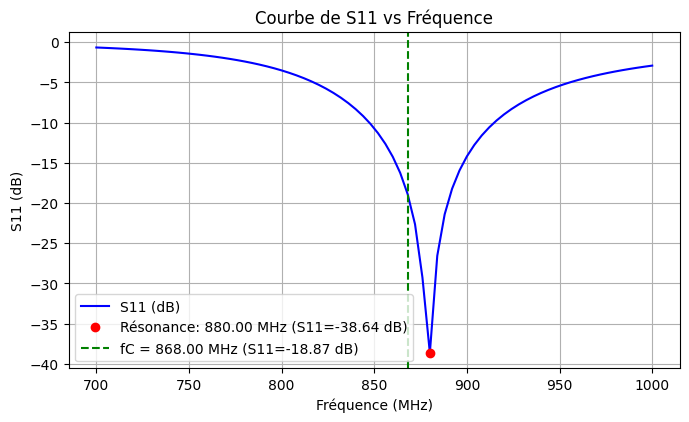


Ratio = 1.0138248847926268


We are within 2% of fc!


------------------------------------------------------Iteration N°4------------------------------------------------------

distance meandres = 5.400 mm

Number of meanders = 2

New distance meandres = 8.100 mm
Largeur de piste ifa = 5.400 mm
position feed = 31.239 mm

Simulation 1/76 | f = 700.00 MHz | S11 = -0.71 dB
Simulation 2/76 | f = 704.00 MHz | S11 = -0.75 dB
Simulation 3/76 | f = 708.00 MHz | S11 = -0.80 dB
Simulation 4/76 | f = 712.00 MHz | S11 = -0.85 dB
Simulation 5/76 | f = 716.00 MHz | S11 = -0.91 dB
Simulation 6/76 | f = 720.00 MHz | S11 = -0.97 dB
Simulation 7/76 | f = 724.00 MHz | S11 = -1.03 dB
Simulation 8/76 | f = 728.00 MHz | S11 = -1.10 dB
Simulation 9/76 | f = 732.00 MHz | S11 = -1.18 dB
Simulation 10/76 | f = 736.00 MHz | S11 = -1.26 dB
Simulation 11/76 | f = 740.00 MHz | S11 = -1.35 dB
Simulation 12/76 | f = 744.00 MHz | S11 = -1.44 dB
Simulation 13/76 | f = 748.00 MHz | S11 = -1.55 dB
Simulation 14/76 | f 

Simulation 43/76 | f = 868.00 MHz | S11 = -32.32 dB
Simulation 44/76 | f = 872.00 MHz | S11 = -26.14 dB
Simulation 45/76 | f = 876.00 MHz | S11 = -21.28 dB
Simulation 46/76 | f = 880.00 MHz | S11 = -18.11 dB
Simulation 47/76 | f = 884.00 MHz | S11 = -15.83 dB
Simulation 48/76 | f = 888.00 MHz | S11 = -14.06 dB
Simulation 49/76 | f = 892.00 MHz | S11 = -12.63 dB
Simulation 50/76 | f = 896.00 MHz | S11 = -11.45 dB
Simulation 51/76 | f = 900.00 MHz | S11 = -10.45 dB
Simulation 52/76 | f = 904.00 MHz | S11 = -9.58 dB
Simulation 53/76 | f = 908.00 MHz | S11 = -8.83 dB
Simulation 54/76 | f = 912.00 MHz | S11 = -8.17 dB
Simulation 55/76 | f = 916.00 MHz | S11 = -7.58 dB
Simulation 56/76 | f = 920.00 MHz | S11 = -7.06 dB
Simulation 57/76 | f = 924.00 MHz | S11 = -6.59 dB
Simulation 58/76 | f = 928.00 MHz | S11 = -6.17 dB
Simulation 59/76 | f = 932.00 MHz | S11 = -5.79 dB
Simulation 60/76 | f = 936.00 MHz | S11 = -5.44 dB
Simulation 61/76 | f = 940.00 MHz | S11 = -5.13 dB
Simulation 62/76 | f =


📡 Résultats de simulation :
→ Fréquence de résonance = 868.00 MHz
→ Impédance à f_res      = 47.76-0.75j Ω

S11 en dB : [ -0.70825539  -0.75291525  -0.80090684  -0.85252703  -0.90810351
  -0.9679984   -1.03261225  -1.10238873  -1.17781969  -1.25945111
  -1.34788967  -1.4438103   -1.54796469  -1.66119103  -1.78442503
  -1.91871263  -2.06522447  -2.22527266  -2.4003301   -2.59205316
  -2.8023082   -3.03320321  -3.28712577  -3.56678944  -3.87529117
  -4.21618383  -4.59356956  -5.01222239  -5.47775303  -5.99683535
  -6.57752537  -7.22972211  -7.9658526   -8.80192295  -9.75919224
 -10.86695985 -12.16746893 -13.72514961 -15.64566001 -18.1198997
 -21.54116223 -26.82026884 -32.32453963 -26.1437122  -21.27718715
 -18.11378602 -15.82724151 -14.05957713 -12.63354794 -11.44950681
 -10.44597371  -9.58230502  -8.83017235  -8.16899231  -7.58330117
  -7.06116105  -6.59314682  -6.17167706  -5.79055715  -5.44465835
  -5.12968644  -4.84201125  -4.57853855  -4.33661189  -4.11393638
  -3.90851851  -3.7186

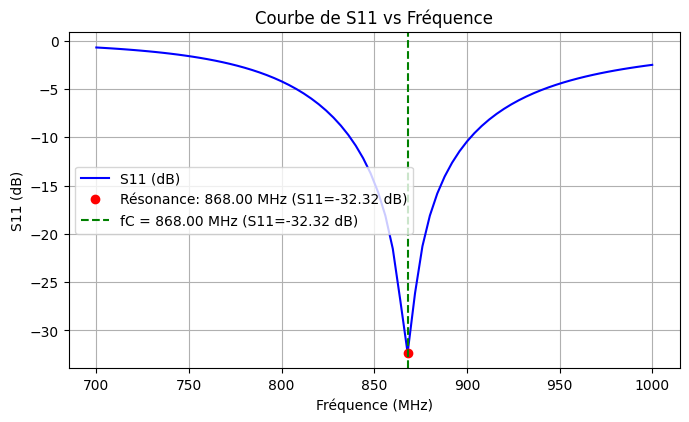


Ratio = 1.0


Required Accuracy is met!
Temps de simulation : 0 minutes et 6.28 secondes
Convergence atteinte à l'itération 4


In [6]:
import time
start_time = time.time()
iteration = 1
max_iter = 20
Accuracy = 0.01
converged = False
while iteration <= max_iter and not converged:
    try:
        print(f"\n------------------------------------------------------Iteration N°{iteration}------------------------------------------------------\n")
        print(f"distance meandres = {distance_meandre * 1000:.3f} mm\n")
        
        N_list_elem, new_distance_meandre_elem = creation_ifa(a, b, largeur_piste, distance_meandre, feed, x_t, y_t, save_mesh_folder, mesh_name, mesh_size)
        print(f"Number of meanders = {N_list_elem}\n")

        print(f"New distance meandres = {new_distance_meandre_elem * 1000:.3f} mm")
        print(f"Largeur de piste ifa = {largeur_piste * 1000:.3f} mm")
        print(f"position feed = {feed * 1000:.3f} mm\n")

        frequence_resonance, s11_db, R_res, X_res = simulate(frequencies, ifa_meander_mat, fC, feed_point)
        Q = calculate_Q(frequencies, s11_db, frequence_resonance)
        plot_s11_curve(fLow, fHigh, nPoints, s11_db, fC)

        ratio = frequence_resonance / fC
        print(f"\nRatio = {ratio}\n")
        # distance_meandre = distance_meandre / ratio

        if (abs((fC - frequence_resonance)/fC) < Accuracy):
            min_index = np.argmin(s11_db)
            min_s11 = s11_db[min_index]
            s11_fc = s11_db[fc_index]
            if s11_fc < -10 or min_s11 < -20:
                converged = True
                print("\nRequired Accuracy is met!")
                break
            else:
                print("\nOn cherche le matching !!!")

                if ratio == 1:
                    print("Ratio == 1 on modifie le feed parce quon a pas une bonne adaptation")
                    ratio_adapt_feed = math.sqrt(R_res / 50)
                    feed = max(min(feed / ratio_adapt_feed, b - 3 * largeur_piste / 2 - 2.5 / 1000), largeur_piste / 2)
                else:
                    adapt_with_ratio_cube(distance_meandre, largeur_piste, ratio)             # New Addd ---- delete maybe

                    feed = max(min(feed * ratio**2, b - 3 * largeur_piste / 2 - 2.5 / 1000), largeur_piste / 2)

                    print(f"\nresultat feed = {feed * 1000:.3f} mm")

                if feed >= b - 3 * largeur_piste / 2 - 2.5 / 1000 or feed <= largeur_piste / 2:
                    distance_meandre, largeur_piste = adapt_with_ratio_square(distance_meandre, largeur_piste, ratio)

                feed_point       = [0, feed, 0]

        elif abs(frequence_resonance - fC) < 0.07 * fC:
            print(f"\nWe are within 2% of fc!\n")
            feed = max(min(feed * ratio**2, b - 3 * largeur_piste / 2 - 2.5 / 1000), largeur_piste / 2)

            if feed >= b - 3 * largeur_piste / 2 - 2.5 / 1000 or feed <= largeur_piste / 2:
                print("\nBord extreme atteint\n")
                distance_meandre, largeur_piste = adapt_with_ratio_square(distance_meandre, largeur_piste, ratio)
            
            feed_point       = [0, feed, 0]
        else:
            print(f"\nWe are FAR of fc!\n")
            distance_meandre, largeur_piste = adapt_with_ratio_square(distance_meandre, largeur_piste, ratio)

            """ # New Add    ---- delete maybe

            feed = max(min(feed * ratio**1, b - 3 * largeur_piste / 2 - 2.5 / 1000), largeur_piste / 2)

            if feed >= b - 3 * largeur_piste / 2 - 0.5 / 1000 or feed <= largeur_piste / 2:
                print("\nBord extreme atteint\n")
                distance_meandre, largeur_piste = adapt_with_ratio_square(distance_meandre, largeur_piste, ratio)
            
            feed_point       = [0, feed, 0]

            # New Add   ---- delete maybe """
        
        iteration += 1
    except ValueError as e:
        print(f"Error: {e}")

end_time = time.time()
simulation_time = end_time - start_time
simulation_time_minutes = simulation_time / 60
simulation_time_seconds = simulation_time % 60
print(f"Temps de simulation : {simulation_time_minutes:.0f} minutes et {simulation_time_seconds:.2f} secondes")
if converged:
    print(f"Convergence atteinte à l'itération {iteration}")
else:
    print(f"Convergence non atteinte après {max_iter} itérations")